# Time Series Forecasting with XGBoost & Cross-Validation 

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
color_pal = sns.color_palette()
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import xgboost as xgb
from sklearn.metrics import mean_squared_error

#cross validation imports
from sklearn.model_selection import TimeSeriesSplit

In [31]:
df = pd.read_csv('PJME_hourly.csv')

### Set Index as Datetime
#df = df.set_index('Datetime')

#Change Datetime Datatype to Datetime
#df.index = pd.to_datetime(df.index)

df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)

## Data Exploration & Cleaning

In [32]:
df

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0


In [4]:
df.shape

(145366, 1)

In [5]:
df.dtypes

PJME_MW    float64
dtype: object

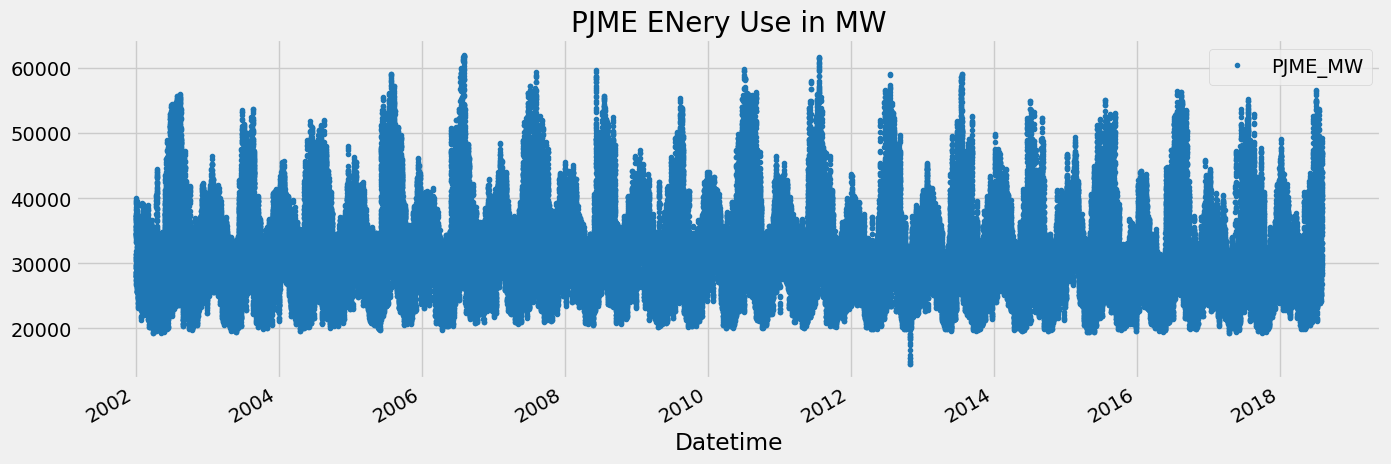

In [37]:
df.plot(style = '.', 
        figsize = (15, 5), 
        color = color_pal[0], 
        title = 'PJME ENery Use in MW');

We can notice some outliers in between 2012-2014, where there are values under 20,000MW. It is better to remove these outliners in order for the model to predict more accurately.  

### Outlier Analysis and Removal

In [38]:
mean_MW = df['PJME_MW'].mean()
mean_MW

32080.222830648156

### Histogram

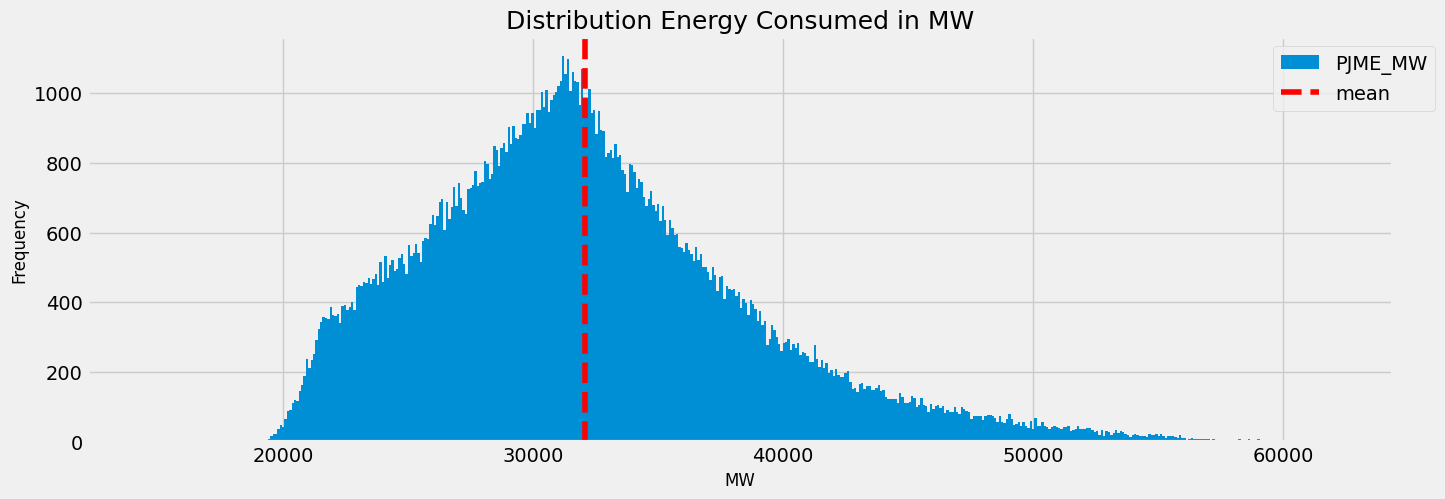

In [39]:
df['PJME_MW'].plot(figsize = (15,5), kind = 'hist', bins = 500)

plt.title('Distribution Energy Consumed in MW', fontsize=18)

plt.xlabel('MW', fontsize=12)

plt.ylabel('Frequency', fontsize=12)

plt.axvline(x=mean_MW, color='r', linestyle = '--', label = 'mean')

plt.legend(bbox_to_anchor=(1.04,1));

### Locate when the values are less than 20,000 MW

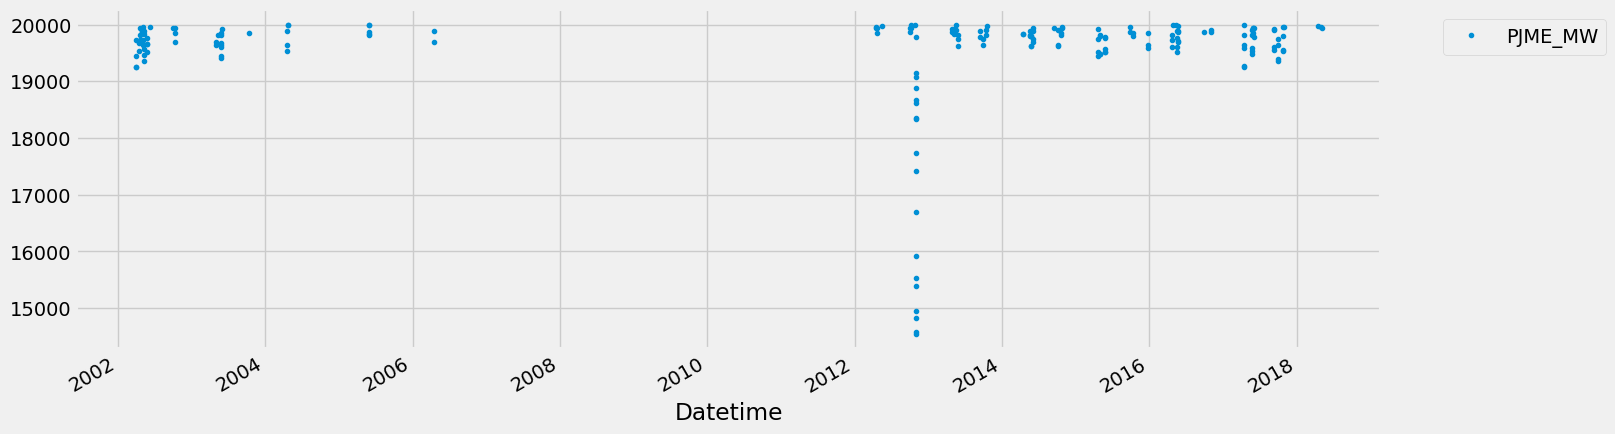

In [40]:
df.query('PJME_MW < 20000').plot(figsize = (15,5), style = '.')
plt.legend(bbox_to_anchor=(1.04,1));

Looks like the values tend to drop below 20,000 MW, however, there are only one specific section, when the values drop below 19,000.

### Locate when the values are less than 19,000 MW

In [44]:
df.query('PJME_MW < 19000')['PJME_MW']

Datetime
2012-10-31 02:00:00    18618.0
2012-10-31 03:00:00    18350.0
2012-10-31 04:00:00    18330.0
2012-10-31 05:00:00    18880.0
2012-10-30 01:00:00    15390.0
2012-10-30 02:00:00    14955.0
2012-10-30 03:00:00    14586.0
2012-10-30 04:00:00    14544.0
2012-10-30 05:00:00    14821.0
2012-10-30 06:00:00    15526.0
2012-10-30 07:00:00    16688.0
2012-10-30 08:00:00    17734.0
2012-10-30 09:00:00    18675.0
2012-10-29 23:00:00    17422.0
2012-10-30 00:00:00    15919.0
Name: PJME_MW, dtype: float64

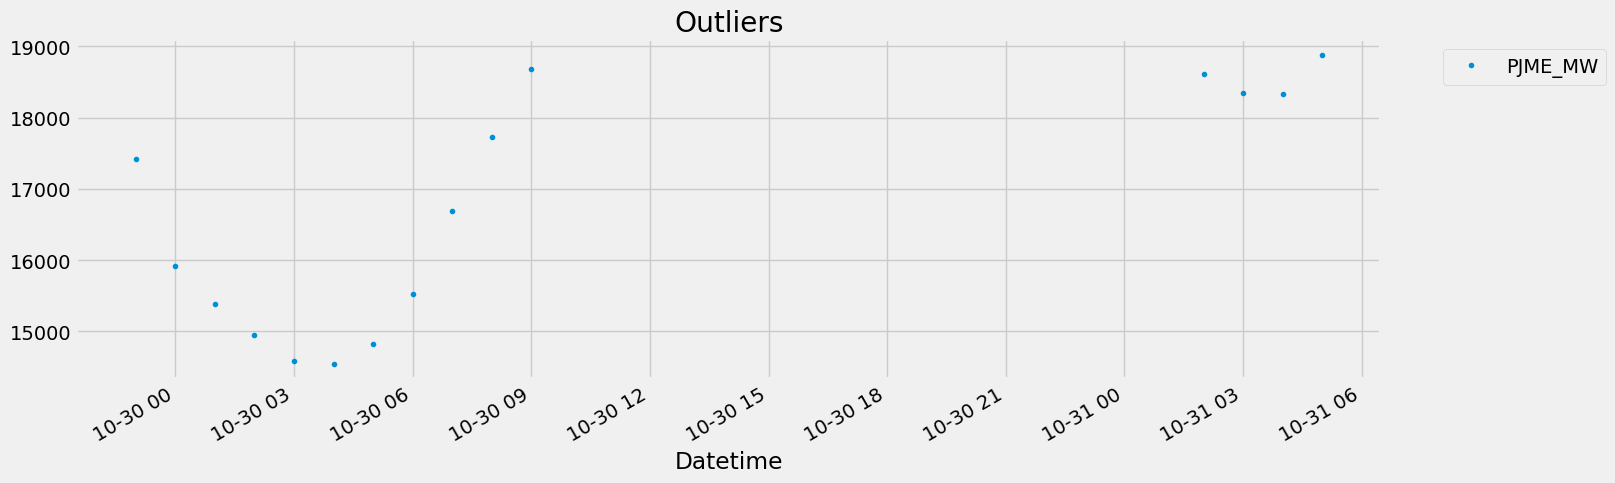

In [43]:
df.query('PJME_MW < 19000')['PJME_MW'].plot(figsize = (15,5), style = '.', title='Outliers')
plt.legend(bbox_to_anchor=(1.04,1))

### Make a Copy of All The Data That Is Over 19,000 MW and Assign it to a New DataFrame

In [186]:
df = df[df['PJME_MW'] > 19000].copy()



## Time Series Cross Validation

In [187]:
tss = TimeSeriesSplit(n_splits = 5, test_size = 24*365*1, gap = 24)
df = df.sort_index()

In [188]:
for train_index, val_index in tss.split(df):
    break

#### Training Set Indices

In [189]:
train_index

array([     0,      1,      2, ..., 101524, 101525, 101526])

#### Validation indices

In [190]:
val_index

array([101551, 101552, 101553, ..., 110308, 110309, 110310])

### Plot Cross Validation Sets

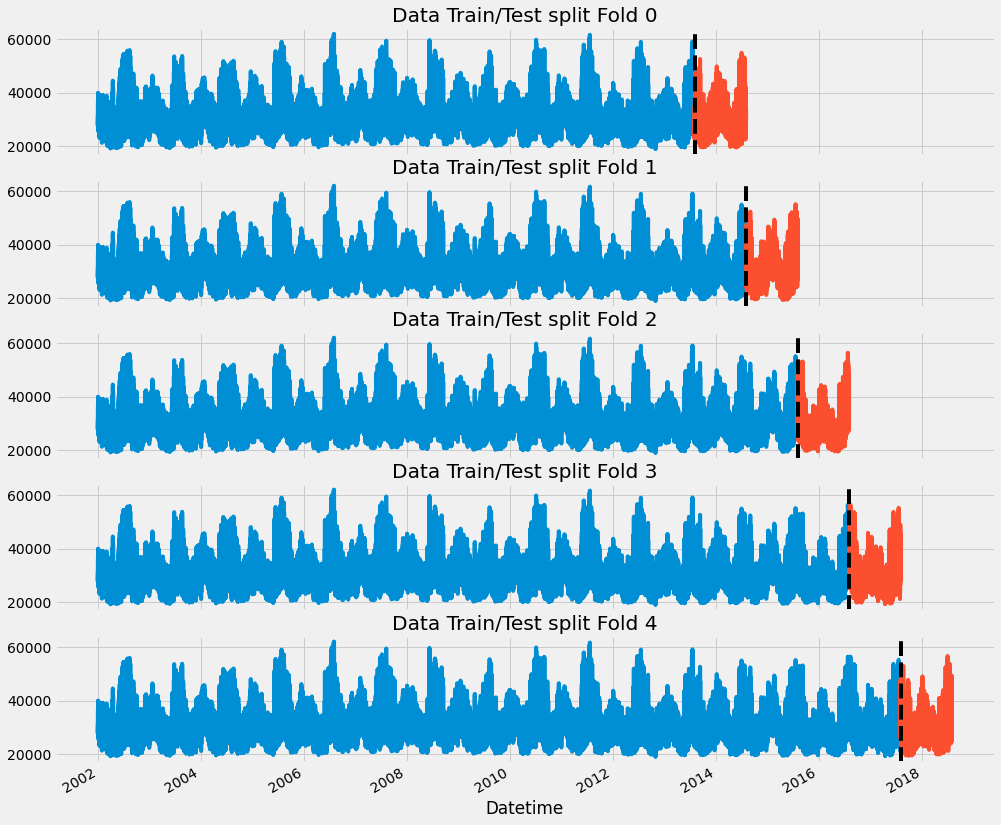

In [191]:
fig, axs = plt.subplots(5, 1,figsize = (15,15), sharex=True)

fold = 0
for train_index, val_index in tss.split(df):
    train =df.iloc[train_index]
    test = df.iloc[val_index]
    train['PJME_MW'].plot(ax = axs[fold],
                         label = 'Training Set',
                         title = f'Data Train/Test split Fold {fold}')
    test['PJME_MW'].plot(ax = axs[fold], label = 'Test Set')
    
    axs[fold].axvline(test.index.min(), color = 'black', ls = '--')
    fold += 1

According to the visualization above, we are testing each of the past 5 years of our data independently to each other.

## Forecasting Horizon Explained

The length of time into future for which forecasts are to be prepared.

### Time Series Features

In [47]:
def create_features(df):
    """
    Create time series features based on time series index. 
    """
    df.copy()
    df['Hour'] = df.index.hour
    df['Day_of_Week'] = df.index.dayofweek
    df['Quarter'] = df.index.quarter
    df['Month'] =  df.index.month
    df['Year'] = df.index.year
    df['Day_of_Year'] = df.index.dayofyear
    df['Day_of_Month'] = df.index.day
    df['Week_of_Year'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [48]:
df

,PJME_MW,Hour,Day_of_Week,Quarter,Month,Year,Day_of_Year,Day_of_Month,Week_of_Year
Datetime,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,31,1
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,31,1
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365,31,1
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365,31,1
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365,31,1
...,...,...,...,...,...,...,...,...,...
2018-01-01 20:00:00,44284.0,20,0,1,1,2018,1,1,1
2018-01-01 21:00:00,43751.0,21,0,1,1,2018,1,1,1
2018-01-01 22:00:00,42402.0,22,0,1,1,2018,1,1,1


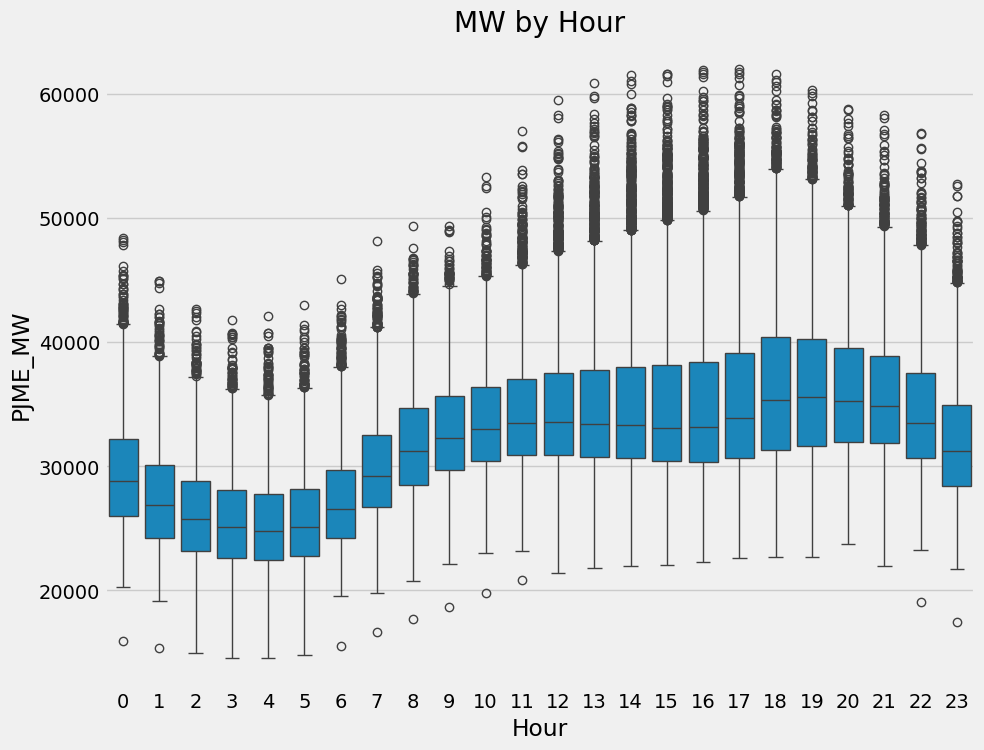

In [50]:
fig, ax= plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='Hour', y='PJME_MW')
ax.set_title('MW by Hour');

C:\Users\enaba\AppData\Local\Temp\ipykernel_16956\1518418144.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Month', y='PJME_MW', palette='Blues')


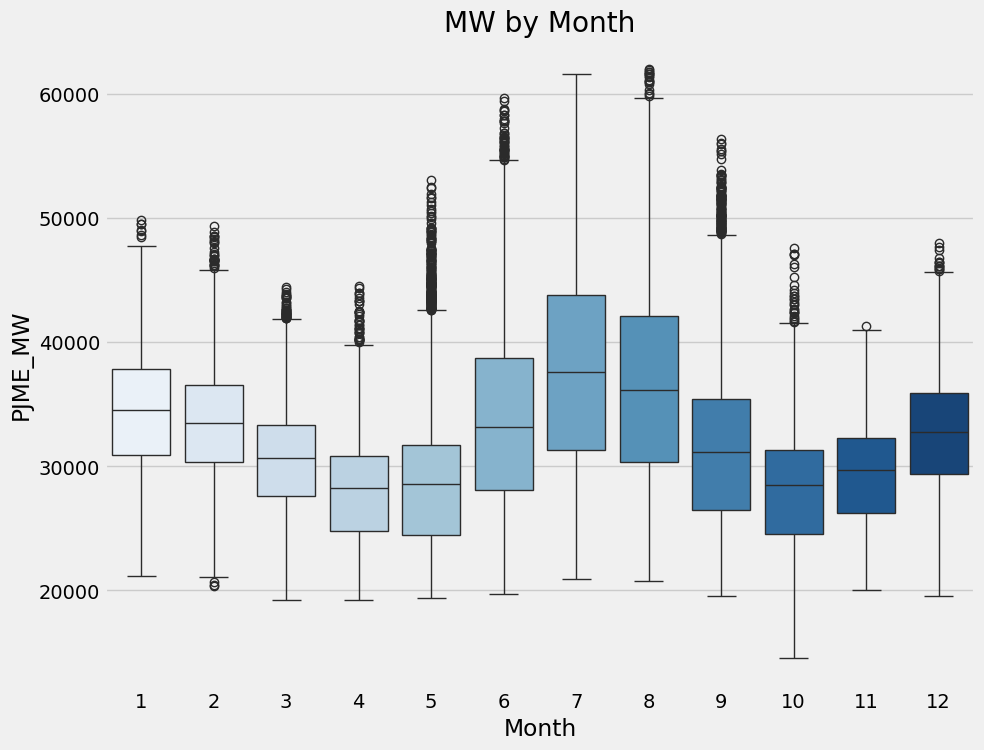

In [51]:
fig, ax= plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='Month', y='PJME_MW', palette='Blues')
ax.set_title('MW by Month');

## Lag Features

States to the model to look back in to past data (as many years/months/days as required) and use the target value for that many days in the past as a new feature to insert into the model.

### Create A Dictinary In Order to Map The Lag Features On To The DataFrame

In [52]:
target_map = df['PJME_MW'].to_dict()

In [53]:
def add_lags(df): 
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [54]:
df = add_lags(df)

In [196]:
df

,PJME_MW,Hour,Day_of_Week,Quarter,Month,Year,Day_of_Year,Day_of_Month,Week_of_Year,lag1,lag2,lag3
Datetime,,,,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,2,31,42256.0,41485.0,38804.0
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,2,31,41210.0,40249.0,38748.0
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,2,31,39525.0,38698.0,37330.0


## Train Using Cross Validation

In [55]:
tss = TimeSeriesSplit(n_splits = 5, test_size = 24*365*1, gap = 24)
df = df.sort_index()

fold = 0
preds = []
scores = []

for train_index, val_index in tss.split(df):
    train =df.iloc[train_index]
    test = df.iloc[val_index]

    ###run the train and test sets through create fetures function 5 different times
    train = create_features(train)
    test = create_features(test)

    ### Define the features including the lags
    FEATURES = ['Hour', 'Day_of_Week', 'Quarter', 'Month', 'Year','Day_of_Year','lag1','lag2','lag3']
    TARGET = 'PJME_MW'
    
    
    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]
    
    reg = xgb.XGBRegressor(base_score = 0.5, booster = 'gbtree',
                           n_estimators = 1000, 
                           early_Stopping_rounds=50,
                           objective = 'reg:linear',
                           max_depth = 3,
                           learning_rate = 0.01)

    reg.fit(X_train, y_train,
           eval_set = [(X_train, y_train), (X_test, y_test)],
           verbose = 100)
    
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    # give score to the model
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    #save the scores into list
    scores.append(score)

C:\Users\enaba\AppData\Local\Temp\ipykernel_16956\3872084641.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Hour'] = df.index.hour
C:\Users\enaba\AppData\Local\Temp\ipykernel_16956\3872084641.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Day_of_Week'] = df.index.dayofweek
C:\Users\enaba\AppData\Local\Temp\ipykernel_16956\3872084641.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

[0]	validation_0-rmse:32730.70639	validation_1-rmse:31956.68992


c:\Users\enaba\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:160: UserWarning: [17:15:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "early_Stopping_rounds" } are not used.

  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12532.55336	validation_1-rmse:11909.41611
[200]	validation_0-rmse:5747.09818	validation_1-rmse:5364.37773
[300]	validation_0-rmse:3873.51430	validation_1-rmse:3899.82339
[400]	validation_0-rmse:3436.83821	validation_1-rmse:3761.31682
[500]	validation_0-rmse:3318.28188	validation_1-rmse:3771.75706
[600]	validation_0-rmse:3262.72071	validation_1-rmse:3789.32199
[700]	validation_0-rmse:3222.65323	validation_1-rmse:3795.34739
[800]	validation_0-rmse:3188.97080	validation_1-rmse:3795.93226
[900]	validation_0-rmse:3158.59891	validation_1-rmse:3777.77118
[999]	validation_0-rmse:3129.75504	validation_1-rmse:3782.84384


C:\Users\enaba\AppData\Local\Temp\ipykernel_16956\3872084641.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Hour'] = df.index.hour
C:\Users\enaba\AppData\Local\Temp\ipykernel_16956\3872084641.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Day_of_Week'] = df.index.dayofweek
C:\Users\enaba\AppData\Local\Temp\ipykernel_16956\3872084641.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

[0]	validation_0-rmse:32670.52224	validation_1-rmse:32138.89280
[100]	validation_0-rmse:12513.49682	validation_1-rmse:12224.28419
[200]	validation_0-rmse:5757.00363	validation_1-rmse:5660.61027
[300]	validation_0-rmse:3906.64261	validation_1-rmse:3931.54029
[400]	validation_0-rmse:3480.55395	validation_1-rmse:3594.18390
[500]	validation_0-rmse:3356.18631	validation_1-rmse:3521.16813
[600]	validation_0-rmse:3300.89593	validation_1-rmse:3485.23578
[700]	validation_0-rmse:3261.72962	validation_1-rmse:3464.90388
[800]	validation_0-rmse:3225.50605	validation_1-rmse:3438.64983
[900]	validation_0-rmse:3197.54901	validation_1-rmse:3430.10289
[999]	validation_0-rmse:3171.60041	validation_1-rmse:3423.28134


C:\Users\enaba\AppData\Local\Temp\ipykernel_16956\3872084641.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Hour'] = df.index.hour
C:\Users\enaba\AppData\Local\Temp\ipykernel_16956\3872084641.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Day_of_Week'] = df.index.dayofweek
C:\Users\enaba\AppData\Local\Temp\ipykernel_16956\3872084641.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

[0]	validation_0-rmse:32629.68486	validation_1-rmse:31073.29137
[100]	validation_0-rmse:12498.98688	validation_1-rmse:11138.61827
[200]	validation_0-rmse:5752.02891	validation_1-rmse:4816.91952
[300]	validation_0-rmse:3919.15626	validation_1-rmse:3552.13740
[400]	validation_0-rmse:3498.18633	validation_1-rmse:3492.25509
[500]	validation_0-rmse:3382.18977	validation_1-rmse:3543.22944
[600]	validation_0-rmse:3322.62047	validation_1-rmse:3587.85684
[700]	validation_0-rmse:3280.13151	validation_1-rmse:3627.82142
[800]	validation_0-rmse:3246.88396	validation_1-rmse:3670.65695
[900]	validation_0-rmse:3220.99777	validation_1-rmse:3702.75857
[999]	validation_0-rmse:3193.61359	validation_1-rmse:3725.37734


C:\Users\enaba\AppData\Local\Temp\ipykernel_16956\3872084641.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Hour'] = df.index.hour
C:\Users\enaba\AppData\Local\Temp\ipykernel_16956\3872084641.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Day_of_Week'] = df.index.dayofweek
C:\Users\enaba\AppData\Local\Temp\ipykernel_16956\3872084641.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

[0]	validation_0-rmse:32527.02577	validation_1-rmse:31475.38351
[100]	validation_0-rmse:12461.96904	validation_1-rmse:12019.48183
[200]	validation_0-rmse:5737.89539	validation_1-rmse:5797.75367
[300]	validation_0-rmse:3915.62082	validation_1-rmse:4384.68884
[400]	validation_0-rmse:3498.63291	validation_1-rmse:4170.01062
[500]	validation_0-rmse:3382.11681	validation_1-rmse:4115.83584
[600]	validation_0-rmse:3323.84410	validation_1-rmse:4104.21226
[700]	validation_0-rmse:3281.57869	validation_1-rmse:4089.73764
[800]	validation_0-rmse:3250.66728	validation_1-rmse:4084.14684
[900]	validation_0-rmse:3223.32980	validation_1-rmse:4071.09428
[999]	validation_0-rmse:3198.63020	validation_1-rmse:4045.58163


C:\Users\enaba\AppData\Local\Temp\ipykernel_16956\3872084641.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Hour'] = df.index.hour
C:\Users\enaba\AppData\Local\Temp\ipykernel_16956\3872084641.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Day_of_Week'] = df.index.dayofweek
C:\Users\enaba\AppData\Local\Temp\ipykernel_16956\3872084641.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

[0]	validation_0-rmse:32460.74594	validation_1-rmse:31463.90740


c:\Users\enaba\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:160: UserWarning: [17:16:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
c:\Users\enaba\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:160: UserWarning: [17:16:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "early_Stopping_rounds" } are not used.

  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12445.48694	validation_1-rmse:11959.07454
[200]	validation_0-rmse:5752.20383	validation_1-rmse:5612.24486
[300]	validation_0-rmse:3950.03192	validation_1-rmse:4153.37990
[400]	validation_0-rmse:3541.82183	validation_1-rmse:4006.17705
[500]	validation_0-rmse:3429.84725	validation_1-rmse:4031.88314
[600]	validation_0-rmse:3375.38523	validation_1-rmse:4052.95634
[700]	validation_0-rmse:3338.24022	validation_1-rmse:4049.80098
[800]	validation_0-rmse:3307.69792	validation_1-rmse:4044.39999
[900]	validation_0-rmse:3280.58400	validation_1-rmse:4036.58352
[999]	validation_0-rmse:3255.36882	validation_1-rmse:4021.85304


### Illustrate the Scores

In [57]:
score

4021.853044045534

In [56]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 3799.7874
Fold scores:[3782.843835924407, 3423.281337516515, 3725.377335774682, 4045.5816272257034, 4021.853044045534]


## Predicting the Future

In [58]:
## Retian on all data
df = create_features(df)

### Define the features including the lags
FEATURES = ['Hour', 'Day_of_Week', 'Quarter', 'Month', 'Year','Day_of_Year',
                'Day_of_Month','lag1','lag2','lag3']
TARGET = 'PJME_MW'
    
X_all = df[FEATURES]
y_all = df[TARGET]
    
reg = xgb.XGBRegressor(base_score = 0.5, 
                       booster = 'gbtree',
                       n_estimators = 1000, 
                       objective = 'reg:linear',
                       max_depth = 3,
                       learning_rate = 0.01)

reg.fit(X_all, y_all, 
        eval_set = [(X_all, y_all)],
        verbose = 100)

[0]	validation_0-rmse:32402.66145


c:\Users\enaba\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:160: UserWarning: [17:28:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12426.65722
[200]	validation_0-rmse:5753.26676
[300]	validation_0-rmse:3974.78237
[400]	validation_0-rmse:3574.03211
[500]	validation_0-rmse:3458.79773
[600]	validation_0-rmse:3403.98354
[700]	validation_0-rmse:3367.48089
[800]	validation_0-rmse:3335.33249
[900]	validation_0-rmse:3308.06820
[999]	validation_0-rmse:3285.56803


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

## Create future DataFrame

In [61]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [62]:
future = pd.date_range('2018-08-03','2019-08-01', freq = '1h')
future_df = pd.DataFrame(index = future)

future_df['isFuture'] = True
df['isFuture'] = False

df_and_future = pd.concat([df, future_df])

# add the features
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)


In [63]:
df_and_future

,PJME_MW,Hour,Day_of_Week,Quarter,Month,Year,Day_of_Year,Day_of_Month,Week_of_Year,lag1,lag2,lag3,isFuture
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,NaN,20,2,3,7,2019,212,31,31,46912.0,39352.0,40243.0,True
2019-07-31 21:00:00,NaN,21,2,3,7,2019,212,31,31,45985.0,38699.0,39183.0,True
2019-07-31 22:00:00,NaN,22,2,3,7,2019,212,31,31,44094.0,37346.0,37759.0,True
2019-07-31 23:00:00,NaN,23,2,3,7,2019,212,31,31,40666.0,34555.0,34641.0,True


In [64]:
future_with_features = df_and_future.query('isFuture').copy()

In [65]:
future_with_features

,PJME_MW,Hour,Day_of_Week,Quarter,Month,Year,Day_of_Year,Day_of_Month,Week_of_Year,lag1,lag2,lag3,isFuture
2018-08-03 00:00:00,NaN,0,4,3,8,2018,215,3,31,33539.0,32094.0,31695.0,True
2018-08-03 01:00:00,NaN,1,4,3,8,2018,215,3,31,30781.0,29503.0,29128.0,True
2018-08-03 02:00:00,NaN,2,4,3,8,2018,215,3,31,29015.0,27712.0,27373.0,True
2018-08-03 03:00:00,NaN,3,4,3,8,2018,215,3,31,27884.0,26535.0,26233.0,True
2018-08-03 04:00:00,NaN,4,4,3,8,2018,215,3,31,27223.0,25870.0,25643.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,NaN,20,2,3,7,2019,212,31,31,46912.0,39352.0,40243.0,True
2019-07-31 21:00:00,NaN,21,2,3,7,2019,212,31,31,45985.0,38699.0,39183.0,True
2019-07-31 22:00:00,NaN,22,2,3,7,2019,212,31,31,44094.0,37346.0,37759.0,True
2019-07-31 23:00:00,NaN,23,2,3,7,2019,212,31,31,40666.0,34555.0,34641.0,True


## Predict the Future

In [66]:
future_with_features['pred'] = reg.predict(future_with_features[FEATURES])

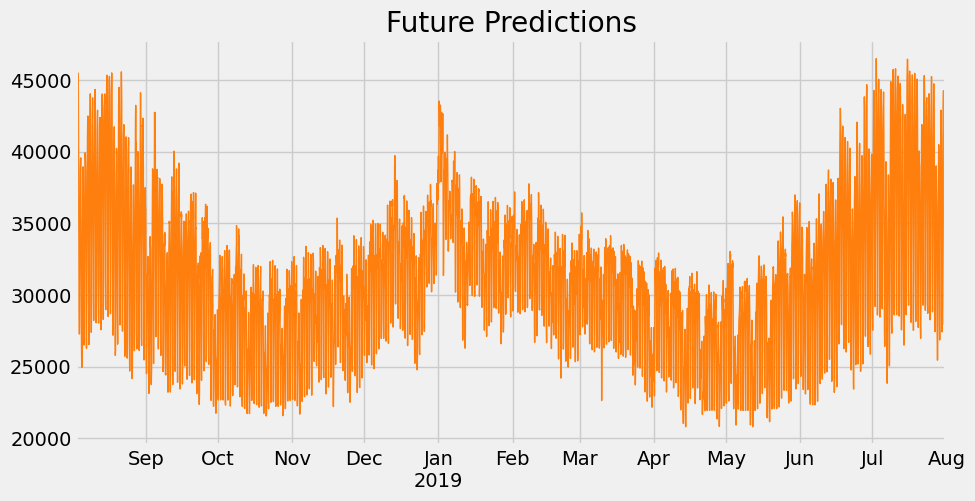

In [68]:
future_with_features['pred'].plot(figsize = (10,5),
                                 color = color_pal[1],
                                 ms=1,
                                 lw=1,
                                 title='Future Predictions');

## Saving the model

In [69]:
reg.save_model('model.json')

XGBoost is a powerful and popular machine learning algorithm, especially for regression and classification tasks. However, like any other algorithm, it has its limitations and considerations when it comes to time series forecasting. Here are some of the limitations of using XGBoost for time series forecasting:

1. Lack of Temporal Understanding:
   - XGBoost is a tree-based model that does not inherently capture the sequential nature of time series data. It treats each data point as independent, which may not be suitable for tasks where the order and time dependencies of data are essential.

2. Stationarity Assumption:
   - XGBoost assumes that the statistical properties of the data do not change over time, which might not hold for many time series data. Time series data often exhibit trends, seasonality, and other temporal patterns that XGBoost may not handle well without proper preprocessing.

3. Seasonality Handling:
   - Dealing with seasonality (e.g., daily, weekly, or yearly patterns) in time series data can be challenging for XGBoost. While some preprocessing techniques can be applied, incorporating seasonality effectively may require domain-specific knowledge.

4. Handling Time Lags:
   - XGBoost doesn't inherently account for time lags, which are often crucial in time series forecasting. Lagged variables or other time-related features must be manually engineered and included in the model.

5. Hyperparameter Tuning:
   - XGBoost requires careful hyperparameter tuning, which can be time-consuming. In time series forecasting, it's essential to find the right balance between model complexity, regularization, and other hyperparameters.

6. Handling Missing Values:
   - Time series data often have missing values due to gaps or irregularities in data collection. Handling missing values appropriately can be challenging, and it requires additional preprocessing steps.

7. Forecast Horizon:
   - XGBoost's forecasting capabilities may be limited when predicting over long time horizons. Forecasts become less accurate as the time horizon increases, and short-term predictions are generally more reliable.

8. Large Datasets:
   - For very large time series datasets, training an XGBoost model can be computationally expensive and may require significant computational resources.

9. Model Interpretability:
   - While XGBoost is a powerful model, its black-box nature may make it challenging to interpret and explain forecasts, which can be important in some applications.

To address these limitations, practitioners often combine XGBoost with other time series forecasting techniques, such as autoregressive models (ARIMA), exponential smoothing (ETS), or Long Short-Term Memory (LSTM) networks, which are better suited for capturing temporal dependencies and handling seasonality. Additionally, preprocessing, feature engineering, and careful consideration of the problem domain play a crucial role in successful time series forecasting using XGBoost.